# Overdispersion Exercises

You'll notice the exercises below are not as guided as exercises in previous lessons. There is not a unique way to successfully solve the exercises. You are encouraged to use all the resources available. Not only the content in this lesson, but also previous lessons, libraries' documentation, books, articles, Google search, etc.

If you come up with a solution that differs from the official one, please share it with us! Discourse or private message are both good. It would be very nice your creative solutions 😄

At the same time, if one of the exercises is more challenging than excepted or simply not clear, reach out so we can clarify it and make it better.

## Imports

In [1]:
import arviz as az
import bambi as bmb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats

In [2]:
%matplotlib inline
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False
FIGSIZE = (7, 4)

## Exercise 1 [Easy]

**_Become a beta-binomial pro_**

In the "It's better to _look_ at it" sub-section of the lesson we created a visualization where we compared the probability mass function of the binomial and beta-binomial distributions. 

1.  All of the distributions in the visualization have something in common, what's that? _Hint: Think about properties that are commonly discussed when characterizing distributions_.
1.  Propose pairs of beta and beta-binomial distributions with the same mean but different variances and plot them. You can use the functions `beta_binomial_mean` and `beta_binomial_variance` provided in the lesson. Before performing the actual computation, think about which distribution will have a larger variance.

### Solution

In [3]:
def beta_binomial_mean(n, alpha, beta):
    return (n * alpha) / (alpha + beta)

def beta_binomial_variance(n, alpha, beta):
    t1 = (n * alpha * beta) / (alpha + beta) ** 2
    t2 = (alpha + beta + n) / (alpha + beta + 1)
    return t1 * t2

**Part 1**

In the visualization in the lesson we can see all the distributions are unimodal and symmetric around $n / 2$. 

What's more, if we have a look at the code in `beta_binomial_mean`, or perform some web searching, we can find the mean of the beta-binomial distribution is 

$$
\mathbb{E}(X) = \frac{n \alpha}{\alpha + \beta} = n \frac{\alpha}{\alpha + \beta}
$$

We can conclude that whenever $\alpha = \beta$, the mean of the beta-binomial distribution will be $n / 2$.

In that particular example, the mean of all the distributions is 15.

**Part 2**

The mean of the binomial distribution is $n p$. One approach to create binomial and beta-binomial distributions with the same mean is to use the same $n$ and make sure to use a $p$ equal to $\alpha / (\alpha + \beta)$.

For example, let's use $n=24$, $\alpha=13$, and $\beta=6$.

In [4]:
n = 24
alpha = 13
beta = 6

p = alpha / (alpha + beta)

print("p:", round(p, 3))
print("Binomial mean:", round(n * p, 3)) 
print("Beta-binomial mean:", round(beta_binomial_mean(n, alpha, beta), 3)) 

p: 0.684
Binomial mean: 16.421
Beta-binomial mean: 16.421


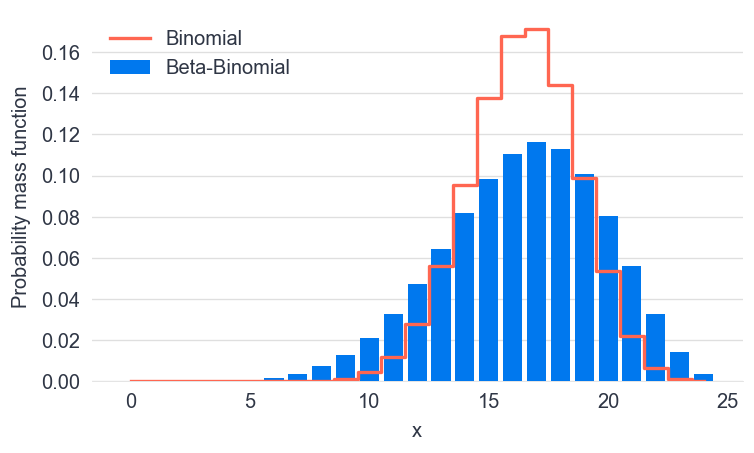

In [5]:
fig, ax = plt.subplots(figsize=FIGSIZE)

x = np.arange(n + 1)

rv = pm.BetaBinomial.dist(alpha, beta, n)
pdf = np.exp(pm.logp(rv, x).eval())
ax.bar(x, pdf, label="Beta-Binomial")
ax.step(x, stats.binom.pmf(x, n, p), color="C4", where="mid", linewidth=2, label="Binomial")
ax.legend()
ax.set(xlabel="x", ylabel="Probability mass function");

From the plot, we can already tell that variances are different because the concentration in the plots are different. However, we can still use the expressions of the variances to get the exact values.

For the binomial distribution, the variance is $n p (1 - p)$. For the beta-binomial, it's a bit more complicated and you can find it in `beta_binomial_variance`. 

Now, let's compute them.

In [6]:
print("Binomial variance:", round(n * p * (1 - p), 3))
print("Beta-binomial variance:", round(beta_binomial_variance(n, alpha, beta), 3))

Binomial variance: 5.186
Beta-binomial variance: 11.149


And there we can see that the variance of the beta-binomial distribution is a bit more than twice the variance of the binomial.

Can we have anticipated this? Yes! The variance of the beta-binomial distribution is never smaller than the variance of the binomial distribution, that's why we use to model "overdispersed" outcomes.

**Bonus**

Before going to the next exercise, I leave you a question: what would you change in $\alpha$ and $\beta$ to have $p$ smaller than 0.5? Also, if you want, keep tweaking the parameters $n$, $\alpha$, and $\beta$ to see how they affect the results. 

## Exercise 2 [Easy]

**_Plot the function $f(\pi) = n \times \pi \times (1 - \pi)$ for values of $\pi \in [0, 1]$ and some fixed values of $n$ of your choice._**

1. What's the maximum value of the function $f(\pi)$? And the minimum?
2. What does it mean for the binomial distribution?

### Solution

In [7]:
# let's propose some 'n'
n = 12
pi = np.linspace(0, 1, num=100)
f = n * pi * (1 - pi)

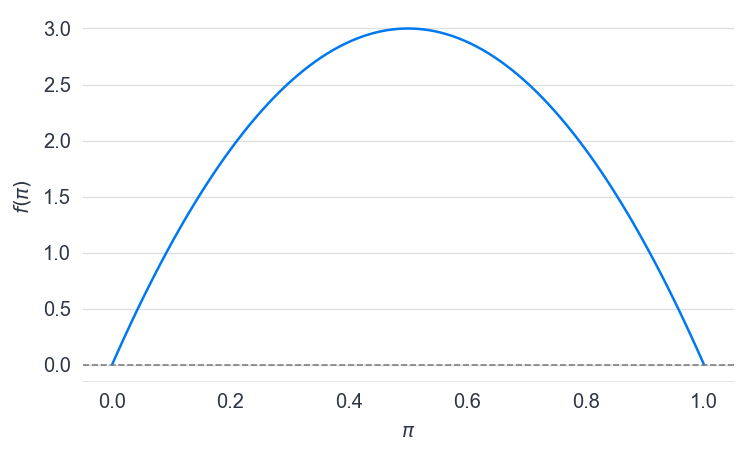

In [8]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(pi, f)
ax.axhline(0, ls="--", lw=1, color="0.5")
ax.set(xlabel="$\\pi$", ylabel="$f(\\pi)$");

**Part 1**

The minimum of $f(\pi)$ occurs whenever $\pi$ is equal to 0 or 1 because both values make $\pi (1-\pi)$ equal to zero and thus $f(\pi)$ is zero no matter the value of $n$. For any other value, $f(\pi)$ is greater than zero.

The maximum of $f(\pi)$ occurs when $\pi (1- \pi)$ is at its maximum. Since $\pi$ is between 0 and 1, this happens when $\pi = 0.5$.

**Part 2**

The function we just evaluated is the one that describes the variance of the binomial distribution. 

The implication is that whenever the probability of success is 0 or 1, the variance is 0. And this makes perfect sense! If $p$ is 0 or 1, all events are either failures or successes, so there's no variability in the observed values.

On the other hand, the heterogeneity beteween the observed values is maximum when the probability of both failures and successes are at their joint maximum (i.e. both are 0.5).

## Exercise 3 [Easy]

**_Compute probabilities based on the observed data and the fitted Poisson distribution._**

In this exercise, use the values in the file `toy_counts.csv` that was introduced in the lesson.

1. Find the maximum likelihood estimate of $\lambda$ assuming $X \sim \mathrm{Poisson}(\lambda)$. _Hint: have a second look at the lesson if you need a refresher on how to do this. Feel free to search on the web for help too._
2. Compute the following probabilities:

$$
\begin{aligned}
& P(X \le 2) \\
& P(X > 10)  \\
& P(4 \le X \le 8)
\end{aligned}
$$

You can use the `.pmf()` method in SciPy's random variables, but you could also implement it yourself.

3. Are there any substantial differences? Why?

### Solution

Let's have a look at the data:

In [9]:
x_values = pd.read_csv("data/toy_counts.csv")["values"].to_numpy()
x_values

array([ 3,  4,  9,  1,  7,  5,  7, 13,  2,  9,  6,  5,  5,  9,  8,  8,  1,
        5,  8,  7, 13,  5,  3,  3,  3,  2, 14,  6,  2,  2, 10,  9,  3,  9,
       10,  7,  8,  2,  6,  2,  3,  3,  9,  5, 16,  3,  8,  4, 10,  2,  4,
        7,  9,  2,  5,  7, 13,  4,  9,  2,  8, 11,  0,  4,  5, 13,  4, 12,
        5,  2,  6, 14,  4,  4,  6,  2,  2,  4,  2,  2,  7,  4, 10,  9,  4,
        8,  5,  6,  7, 11,  3, 11, 12,  6,  8,  5, 11,  6,  5,  1,  3,  9,
        6,  9,  4,  8,  5,  9,  3,  2,  4,  5,  7, 10,  2,  3,  5,  8,  4,
        6,  6,  3,  6,  7,  3, 10,  2,  8,  9, 13, 11,  4,  5, 12,  9,  4,
        6,  4,  8,  7, 17,  8,  6, 16,  8,  6,  5,  7,  4,  7,  2,  4,  6,
       12,  3,  5,  9,  1,  5,  7,  6,  1,  3,  8,  4,  2,  5,  1, 10,  7,
       11,  9,  0,  6, 11, 11,  6,  5,  3,  9,  8, 13,  6,  4,  4,  4,  6,
        0,  7,  8, 13,  7,  6,  7,  7, 13,  5,  3,  0, 10,  6,  4,  2, 12,
        6,  4,  6,  4,  3,  7,  5, 17, 10,  9,  7,  3,  1,  5,  7,  4,  1,
        8,  8,  6,  1,  6

**Part 1**

As we saw in the lesson, the maximum likelihood estimate of $\lambda$ is the mean of the observed values.

$$
\hat{\lambda}_\text{ML} = \bar{x}
$$

In [10]:
lambda_ml = np.mean(x_values)
print(lambda_ml)

6.108


**Part 2**

To compute the probabilities using the maximum likelihood estimate, we can create a SciPy random variable, passing the maximum likelihood estimate as the parameter value.

In [11]:
poisson_rv = stats.poisson(lambda_ml)

Then, we simply evaluate the probability mass function at the points determined by the requested interval and add the probabilities up.

The first probability $P(X \le 2)$ is $P(X = 0) + P(X = 1) + P(X = 2)$. We just do:

In [12]:
poisson_rv.pmf([0, 1, 2]).sum()

0.05731998238797275

To compute $P(X > 10)$ we would need to perform a sum over an infinite number of values of $X$. But since the total probability is 1, we can do 1 minus the  
complement, i.e. $P(X > 10) = 1 - P(X \le 10)$.

In [13]:
1 - poisson_rv.pmf([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).sum()

0.047243649801891996

And finally, $P(4 \le X \le 8)$:

In [14]:
poisson_rv.pmf([4, 5, 6, 7, 8]).sum()

0.6940638301862391

To compute the empirical probabilities, we count how many values are within the desired interval and divide that number by the total number of values. This is the good old Monte Carlo.

In [15]:
print((x_values <= 2).mean())                     # P(X <= 2)
print((x_values > 10).mean())                     # P(X > 10)
print(((4 <= x_values) & (x_values <= 8)).mean()) # P(4 <= X <= 8)

0.156
0.114
0.538


**Part 3**

Indeed there are major differences. For the first two probabilities, which are tail probabilities, using the Poisson distribution **underestimates** the empirical probabilities (0.057 vs 0.156 and 0.047 vs 0.114). On the other hand, when we compute a probability in the bulk of the distribution, using the Poisson distribution **overestimates** the empirical probability. In other words, the Poisson distribution puts more certainty around the bulk of the distribution (does it ring a bell?)

It will be helpful to have a second look at a visualization we showed in the lesson.

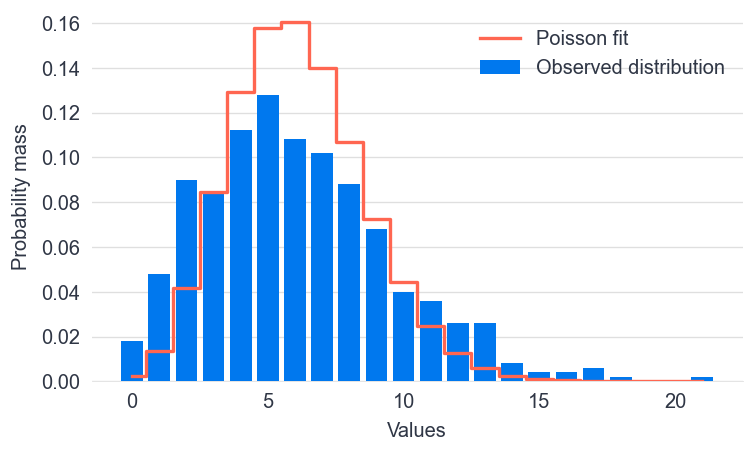

In [16]:
fig, ax = plt.subplots(figsize=FIGSIZE)

values, counts = np.unique(x_values, return_counts=True)  
poisson_pmf = poisson_rv.pmf(values)

ax.bar(values, counts / counts.sum(), label="Observed distribution")
ax.step(values, poisson_pmf, color="C4", where="mid", linewidth=2, label="Poisson fit")
ax.legend()
ax.set(xlabel="Values", ylabel="Probability mass", ylim=(0, 0.165));

Here we can see the variability in the Poisson distribution is smaller than the variability than the observed distribution. In other words, the dispersion of the chosen distribution underestimates the dispersion in the data... Yes, an overdispersion problem.

The conclusion is that whenever we have an overdispersion problem, we may not be obtaining biased estimates of the mean (the observed mean and the mean of the Poisson distribution are the same here), but it certainly affects the computation of probabilities of interest and that's undoubtedly not what we want. For that reason, we have lesson 8 to learn how to handle the overdispersion problem :)

## Exercise 4 [Medium]

**_Modeling of binomial outcomes with PyMC._**

In this exercise we're going to revisit the UC Berkeley admissions problem with PyMC.

1.  Reproduce the binomial model for graduate admissions using PyMC.
2.  Compute the coverage of the 95% HDI of the posterior predictive distribution.
3.  What are your conclusions about this model?
4.  Now, consider both gender and department as a covariates and repeat points 1 to 3. Compare the estimation of the gender coefficient between the two models and conclude.

### Solution

Let's start by importing the dataset.

In [17]:
df_admissions = pd.read_csv("data/UCBadmit.csv")
df_admissions

,dept,gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


**Part 1**

There's no need to perform any EDA here as it was already done it in the lesson. We can jump right into the PyMC model.

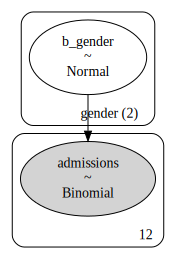

In [18]:
# Array with number of successes 'y'
admit = df_admissions["admit"].to_numpy()

# Array with number of trials 'n'
applications = df_admissions["applications"].to_numpy()

# Obtain the levels of gender and vector of the corresponding indexes
gender, gender_idx = np.unique(df_admissions["gender"], return_inverse=True)

coords = {"gender": gender}

with pm.Model(coords=coords) as model_admissions:
    b_gender = pm.Normal("b_gender", mu=0, sigma=2, dims="gender")
    mu = b_gender[gender_idx]
    p = pm.math.invlogit(mu)
    pm.Binomial("admissions", p=p, n=applications, observed=admit)
    
model_admissions.to_graphviz()

**Part 2**

Let's fit the model and sample from the posterior predictive distribution. 

In [19]:
with model_admissions:
    idata_admissions = pm.sample(chains=4, random_seed=1234)
    idata_admissions.extend(pm.sample_posterior_predictive(idata_admissions, random_seed=1234))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b_gender]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [admissions]


Have a look at the returned `inferenceData` object. It contains both the `posterior` and `posterior_predictive` groups.

In [20]:
idata_admissions

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

We're interested in the coverage of the **predictive** distribution, so we need to look for the admissions in the `posterior_predictive` group.

To compute the HDIs, we use some help from ArviZ as it makes it very easy to do.

In [21]:
admissions_hdi = (
    az.hdi(idata_admissions.posterior_predictive, hdi_prob=0.95)["admissions"].to_numpy()
)
admissions_hdi

array([[334., 397.],
       [ 22.,  41.],
       [223., 273.],
       [  2.,  11.],
       [125., 162.],
       [153., 204.],
       [164., 206.],
       [ 94., 132.],
       [ 72.,  98.],
       [ 98., 137.],
       [145., 185.],
       [ 84., 120.]])

In the array above, each row contains the lower and upper bounds of the 95% HDI for every observation in the `df_admissions` dataset.

In [22]:
is_within_hdi = (admit >= admissions_hdi[:, 0]) & (admit <= admissions_hdi[:, 1])
print("Is the observed value within the corresponding HDI?:\n", is_within_hdi)
print("\nCoverage of the 95% HDIs:", round(is_within_hdi.mean() * 100, 2))

Is the observed value within the corresponding HDI?:
 [False False False False False  True False  True False False False False]

Coverage of the 95% HDIs: 16.67


**Part 3**

Definitely, the coverage is really bad. Only in 2 out 12 cases (16.67%) the posterior 95% HDI of the predictive distribution contains the observed value. As we saw in the lesson, this is a symptom of some problem.

**Part 4**

This time we have not only one, but two categorical predictors. For this reason, we use a zero sum constraint in the parameter vector of the department covariate (we don't want to fight with non-identifiabilities!).

All the rest is similar to what is shown above.

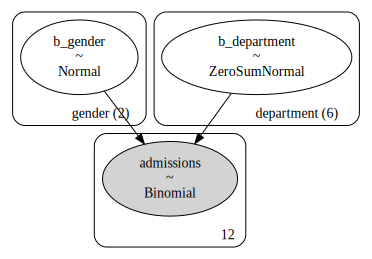

In [23]:
admit = df_admissions["admit"].to_numpy()
applications = df_admissions["applications"].to_numpy()

gender, gender_idx = np.unique(df_admissions["gender"], return_inverse=True)
dept, dept_idx = np.unique(df_admissions["dept"], return_inverse=True)

coords = {
    "gender": gender, 
    "department": dept
}

with pm.Model(coords=coords) as model_admissions_2:
    b_gender = pm.Normal("b_gender", mu=0, sigma=2, dims="gender")
    b_department = pm.ZeroSumNormal("b_department", dims="department")
    
    mu = b_gender[gender_idx] + b_department[dept_idx]
    p = pm.math.invlogit(mu)
    
    pm.Binomial("admissions", p=p, n=applications, observed=admit)
    
model_admissions_2.to_graphviz()

In [24]:
with model_admissions_2:
    idata_admissions_2 = pm.sample(chains=4, random_seed=1234)
    idata_admissions_2.extend(pm.sample_posterior_predictive(idata_admissions_2, random_seed=1234))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b_gender, b_department]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [admissions]


In [25]:
admissions_hdi = (
    az.hdi(idata_admissions_2.posterior_predictive, hdi_prob=0.95)["admissions"].to_numpy()
)
admissions_hdi

array([[487., 563.],
       [ 60.,  81.],
       [319., 382.],
       [ 11.,  20.],
       [ 88., 129.],
       [180., 240.],
       [112., 159.],
       [108., 152.],
       [ 32.,  59.],
       [ 79., 123.],
       [ 14.,  36.],
       [ 12.,  35.]])

In [26]:
is_within_hdi = (admit >= admissions_hdi[:, 0]) & (admit <= admissions_hdi[:, 1])
print("Is the observed value within the corresponding HDI?:\n", is_within_hdi)
print("\nCoverage of the 95% HDIs:", round(is_within_hdi.mean() * 100, 2))

Is the observed value within the corresponding HDI?:
 [ True False  True  True  True  True  True  True  True  True  True  True]

Coverage of the 95% HDIs: 91.67


The coverage improved substantially! The difference between 95% and 91.67% is not meaningful. Given the few data points, it's expected for both values not to match perfectly. 

What does it mean? It means that under the current model, a binomial regression including both gender and deparment (additively), the observed values are "likely"
under the posterior predictive distribution. In other words, the values we observed could have been the result of the data generating process implied in our model (if you want a third option you can say the observed values are consistent with the model predictions).

To finalize the exercise, let's have a look at the posterior of the gender coefficients of both models using a forest plot.

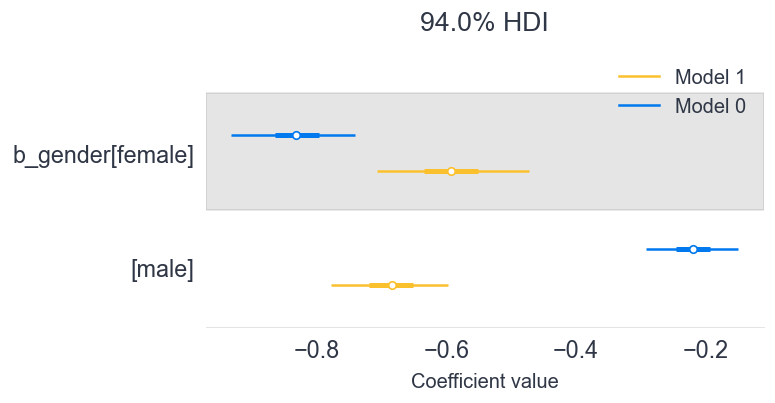

In [27]:
fig, ax = plt.subplots(figsize=(6, 3))

az.plot_forest(
    [idata_admissions, idata_admissions_2], 
    var_names="b_gender", 
    combined=True,
    ax=ax
)
ax.set(xlabel="Coefficient value");

With the first model, it's clear the coefficients of the two genders are different -- males are more likely to be admitted than females as the posterior of `b_gender[male]` is clearly shifted to the right. 

However, once the model accounts for the department, both distributions overlap substantially, not allowing us to conclude that one of the genders is more likely to be admitted than the other.

Finally, this exercise shows one of the reasons that are behind overdispersion: the problem of omitted covariates. Although the main goal is to understand the association between gender and admission rates, it turns out it's also important to account for other relevant covariates such as department.

## Exercise 5 [Medium]

**_Comparing Poisson vs negative binomial predictive distributions._**

In the beginning of the lesson we introduced the fish species diversity dataset. There we create a model (actually two models) to understand the association between the size of a lake and the number of species in it and be able to predict the number the number of species given a lake size.

Now it's time to do some work on that dataset with our favorite probabilistic programming language: PyMC.

1. Reproduce the Poisson regression model with PyMC and get the predictive distribution of the number of species in a lake of 1000 squared meters.
2. Same as #1, but using the negative binomial regression model.
3. Compare the predictive distributions obtained in #1 and #2. Compare their means and variances and explain the result.
4. How would you do the same in Bambi?

### Solution

First things first: import the data.

In [28]:
df_lakes = pd.read_csv("data/lakes.csv")
df_lakes

,fish,lake_area
0,10,5
1,37,41
2,60,171
3,113,25719
4,99,59596
...,...,...
65,5,8
66,40,8264
67,18,9065
68,20,357


**Part 1**

Let's create the PyMC Poisson regression model. You should be familiar with this from Lesson 7. Nevertheless, you have the inline comments which may be of help.

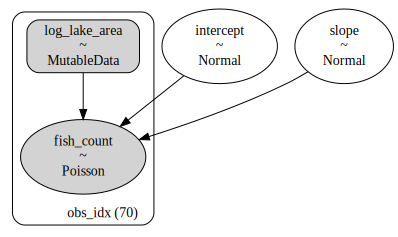

In [29]:
# Get the values of the response variable and the predictor
# This is not strictly needed but I like numpy arrays more than pandas series
fish_count = df_lakes["fish"].to_numpy()
lake_area = df_lakes["lake_area"].to_numpy()

# Create coords dictionary. It only contains the observation indexes.
# We need this because we're going to use the model to make out of sample predictions.
coords = {
    "obs_idx": np.arange(df_lakes.shape[0])
}

# Notice we use 'coords_mutable' because the values in 'obs_idx' will be updated
with pm.Model(coords_mutable=coords) as model_poisson:
    # log_lake_area goes into a mutable data container, as it will be updated below
    log_lake_area_data = pm.MutableData("log_lake_area", np.log(lake_area), dims="obs_idx")

    # Normal intercept and slopes. 
    # You can perform prior elicitation but it's not the main point in the exercise
    intercept = pm.Normal("intercept")
    slope = pm.Normal("slope")

    # Use the exponential inverse link function
    mu = np.exp(intercept + slope * log_lake_area_data)

    # Poisson likelihood
    pm.Poisson("fish_count", mu=mu, observed=fish_count, dims="obs_idx")
 
model_poisson.to_graphviz()

Fit the model as usual.

In [30]:
with model_poisson:
    idata_poisson = pm.sample(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


And now we update the data containers and obtain the posterior predictive distribution. See inline comments.

In [31]:
with model_poisson:
    # Update _both_ the 'log_lake_area' container and 'obs_idx'.
    # Notice they have to be 1d arrays, as the original values we passed to PyMC
    # There's nothing special in '99', it's just a number that was not within the original range
    pm.set_data(
        new_data={"log_lake_area": np.log([1000])},
        coords={"obs_idx": np.array([99])} 
    )

    # Sample from the posterior predictive distribution
    prediction_poisson = pm.sample_posterior_predictive(
        idata_poisson,
        predictions=True,
        random_seed=1234
    )

Sampling: [fish_count]


See we have a `predictions` group with a `"fish_count"` variable.

In [32]:
prediction_poisson.predictions["fish_count"].sel(obs_idx=99)

<xarray.DataArray 'fish_count' (chain: 2, draw: 1000)>
array([[35, 37, 27, ..., 38, 28, 35],
       [40, 27, 33, ..., 34, 37, 45]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    obs_idx  int64 99

Just a reminder, when we sample the predictive distribution, we obtain as many draws as draws from the posterior because each draw in the posterior is used to sample a value from the predictive distribution.

**Part 2**

Everything here follows the approach shown in Part 1. The only difference you will notice is the presence of the `alpha` parameter. We use the same prior than in the lesson.

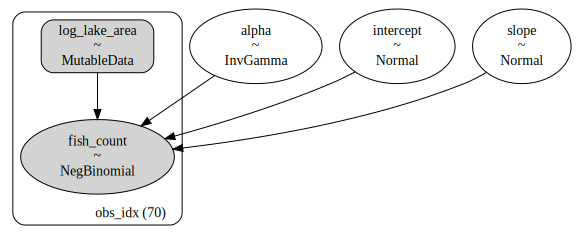

In [33]:
with pm.Model(coords_mutable=coords) as model_nb:
    log_lake_area_data = pm.MutableData("log_lake_area", np.log(lake_area), dims="obs_idx")

    intercept = pm.Normal("intercept")
    slope = pm.Normal("slope")

    # Use the exponential inverse link function
    mu = np.exp(intercept + slope * log_lake_area_data)
    alpha = pm.InverseGamma("alpha", alpha=4, beta=2)

    pm.NegativeBinomial("fish_count", mu=mu, alpha=alpha, observed=fish_count, dims="obs_idx")
 
model_nb.to_graphviz()

In [34]:
with model_nb:
    idata_nb = pm.sample(random_seed=1234)

    pm.set_data(
        new_data={"log_lake_area": np.log([1000])},
        coords={"obs_idx": np.array([99])}
    )

    prediction_nb = pm.sample_posterior_predictive(
        idata_nb,
        predictions=True,
        random_seed=1234
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [fish_count]


**Part 3**

Now that we have draws from the posterior predictive distribution of a lake of 1000 squared meters with both models, we can proceed to compare them.

Here you can use your preferred tool. I decided to extract the draws as NumPy arrays and create a visualization with plain Matplotlib. You could also use ArviZ and it would be great.

Extract the draws as 1d arrays.

In [35]:
values_poisson = prediction_poisson.predictions.sel(obs_idx=99)["fish_count"].to_numpy().flatten()
values_nb = prediction_nb.predictions.sel(obs_idx=99)["fish_count"].to_numpy().flatten()

Create the visualization. Notice this is a step function to reflect the fact that we got integer values, not values with decimals. If you want a smoother curve, you can use a density estimate, but keep in mind draws are integers because they represent a count of fish species.

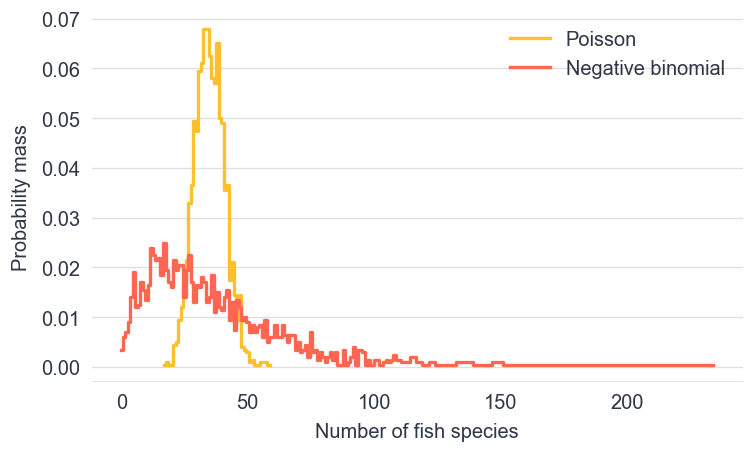

In [36]:
fig, ax = plt.subplots(figsize=FIGSIZE)

# Get the values of 'x' and 'y' for both cases
x_poisson, counts_poisson = np.unique(values_poisson, return_counts=True)
x_nb, counts_nb = np.unique(values_nb, return_counts=True)

# Plot the distributions using a step function.
# Notice the division by the sum so the heights add up to one.
ax.step(x_poisson, counts_poisson / counts_poisson.sum(), color="C1", where="mid", linewidth=2, label="Poisson")
ax.step(x_nb, counts_nb / counts_nb.sum(), color="C4", where="mid", linewidth=2, label="Negative binomial")
ax.legend()

ax.set(xlabel="Number of fish species", ylabel="Probability mass");

Before writing any conclusions, let's have a look at the mean and variance of each distribution.

In [37]:
print(f"Poisson model. Mean: {values_poisson.mean():.2f}, Variance {values_poisson.var():.2f}.")
print(f"Negative binomial model. Mean: {values_nb.mean():.2f}, Variance {values_nb.var():.2f}.")

Poisson model. Mean: 34.82, Variance 34.53.
Negative binomial model. Mean: 35.28, Variance 669.47.


It's not surprising to see the variance of the predictive distribution generated with the negative binomial model is larger than the one from the Poisson model. However, it may still be surprising to see their means are virtually the same.

This is something we already saw in the plot of the mean and HDIs of the conditional posterior predictive distributions. The mean predictive lines were similar, what was quite different were the variances. Just like what we see here. 

All in all, this allows us to conclude models based on Poisson likelihoods can result in overconfident predictions.

**Part 4**

To do this in Bambi we need to:

1. Create the models using `family="poisson"` and `family="negativebinomial"`. The formula is `"fish ~ 1 + log(lake_area)"` in both cases and they are already included in the lesson.

```python
model_poisson = bmb.Model("fish ~ 1 + log(lake_area)", data, family="poisson")
model_nb = bmb.Model("fish ~ 1 + log(lake_area)", data, family="negativebinomial")
```

2. Obtain the predictive distribution for a new observation. To do that, we create a new data frame with only one observation with a `lake_area` equal to 1000 and use `.predict()` with `kind="pps"` and `inplace=False`

```python
df_new = pd.DataFrame({"lake_area": [1000]})

idata_poisson = model_poisson.fit()
model_poisson.predict(idata_poisson, data=df_new, kind="pps", inplace=False)

idata_nb = model_nb.fit()
model_nb.predict(idata_nb, data=df_new, kind="pps", inplace=False)
```

3. Use the draws in `idata_poisson.posterior_predictive["fish"]` and `idata_nb.posterior_predictive["fish"]` as above.

The steps required to analyze the draws are the same than those the part 3 of this exercise.

## Exercise 6 [Medium/Hard]

**_Analysis of trout eggs._**

The `troutegg.csv` file contains the **troutegg** dataset, which contains information about the survival of trout eggs according to different times and locations.  

Boxes of trout eggs were buried at 5 different stream locations and retrieved at 4 different times, and the number of surviving eggs was recorded.

The data frame contains 20 observations with the following 4 variables:

* **survive** the number of surviving eggs.
* **total** the number of eggs in the box.
* **location** the location in the stream (1, 2, 3, 4, and 5).
* **period** the number of weeks after placement that the box was withdrawn (4, 7, 8, and 11).

**Note**: Consider both `location` and `period` as categoric covariates.

1.  Explore the dataset. Do you spot any challenges?
2.  Use Bambi to:
    1. Build two binomial models: one with additive and other with interaction effects
    1. Build two beta binomial models: one with additive and other with interaction effects
3.  What is the estimated survival probability for the following cases in the dataset? Estimate the posterior with the four models and plot all of them together using a forest plot.
    * `location == 4` and `period == 4`
    * `location == 4` and `period == 8`
    * `location == 5` and `period == 11`
4.  For the cases listed in #3, get and visualize the predictive distribution along the observed number of eggs that survive.
5.  Which model do you think makes most sense? List pros and cons of both models.

In part 2, **it's OK to use default priors** as prior elicitation is not the goal of the exercise.

### Solution

**Part 1**

Let's load the dataset. It's so small that we can directly print it and inspect all the numbers in there.

In [38]:
df_eggs = pd.read_csv("data/trout_egg.csv")
df_eggs

,survive,total,location,period
0,89,94,1,4
1,106,108,2,4
2,119,123,3,4
3,104,104,4,4
4,49,93,5,4
5,94,98,1,7
6,91,106,2,7
7,100,130,3,7
8,80,97,4,7
9,11,113,5,7


We can see the number of eggs in the boxes are between 86 and 155. It's hard to tell by naked what are the empirical survival probabilities.
Let's compute them.

In [39]:
df_eggs.assign(p_surv = df_eggs["survive"] / df_eggs["total"]).sort_values("p_surv")

,survive,total,location,period,p_surv
19,0,138,5,11,0.000000
9,11,113,5,7,0.097345
14,18,88,5,8,0.204545
4,49,93,5,4,0.526882
13,67,99,4,8,0.676768
17,91,125,3,11,0.728000
12,88,119,3,8,0.739496
7,100,130,3,7,0.769231
8,80,97,4,7,0.824742
18,111,132,4,11,0.840909


There are a couple of facts we can list:

* In all but three cases, more than half of the eggs surive.
* Shorter periods are associated with higher survival probabilities -- this is expected.
* There are two interesting (and potentially challenging) cases:
    * When period is 11 and location is 5, none of the 138 eggs survived. What happened?! In other locations, the proportion of eggs alive is not that low by the 11th week.
    * When period is 4 and location is 4, all the 104 eggs in the box survived. This is less surprising, but it can still impose some problems as the empirical estimate is in the boundary of the parameter space.

**Part 2**

It's time to create the models with Bambi. You should be familiar with additive and interaction effects from previous lessons (but please feel free to start a discussion on Discourse if you have questions!). 

First we create the two binomial models, and then the two beta binomials.

In [40]:
bmb_model_additive = bmb.Model(
    "p(survive, total) ~ 1 + location + period", 
    df_eggs, 
    family="binomial", 
    categorical=["location", "period"]
)

bmb_model_interaction = bmb.Model(
    "p(survive, total) ~ 0 + location:period", 
    df_eggs, 
    family="binomial", 
    categorical=["location", "period"]
)

bmb_model_bb_additive = bmb.Model(
    "p(survive, total) ~ 1 + location + period", 
    df_eggs, 
    family="beta_binomial", 
    categorical=["location", "period"]
)

bmb_model_bb_interaction = bmb.Model(
    "p(survive, total) ~ 0 + location:period", 
    df_eggs, 
    family="beta_binomial", 
    categorical=["location", "period"]
)

Next we need to get the posterior. It's just a line of code per model.

In [41]:
idata_model_additive = bmb_model_additive.fit(random_seed=12)
idata_model_interaction = bmb_model_interaction.fit(random_seed=12)
idata_model_bb_additive = bmb_model_bb_additive.fit(random_seed=12)
idata_model_bb_interaction = bmb_model_bb_interaction.fit(random_seed=12)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, location, period]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [location:period]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p(survive, total)_kappa, Intercept, location, period]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p(survive, total)_kappa, location:period]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


**Part 3**

The cases required correspond to indexes 13, 9, and 3 of the data frame that we used to fit the model.

In [42]:
df_scenarios = df_eggs.iloc[np.array([13, 19, 3])]
df_scenarios

,survive,total,location,period
13,67,99,4,8
19,0,138,5,11
3,104,104,4,4


We use `.predict` to get the posterior distribution of the survival probability. Given that we also need the posterior predictive draws in **Part 4**, we do all at once here passing `kind="pps"`.

In [43]:
bmb_model_additive.predict(idata_model_additive, data=df_scenarios, kind="pps")
bmb_model_interaction.predict(idata_model_interaction, data=df_scenarios, kind="pps")
bmb_model_bb_additive.predict(idata_model_bb_additive, data=df_scenarios, kind="pps")
bmb_model_bb_interaction.predict(idata_model_bb_interaction, data=df_scenarios, kind="pps")

Now, the visualization. There are a couple of things we can highligth here

* We pass a list of `InferenceData`s to `az.plot_forest` and a list with labels. This makes it easier to plot all the posteriors together.
* The variable name in `var_names` is `p(survive_total)_mean` because Bambi appends `mean` to what we passed to the left of `~` in the formula string. You can also find it in the `posterior` group in the `InferenceData` objects.

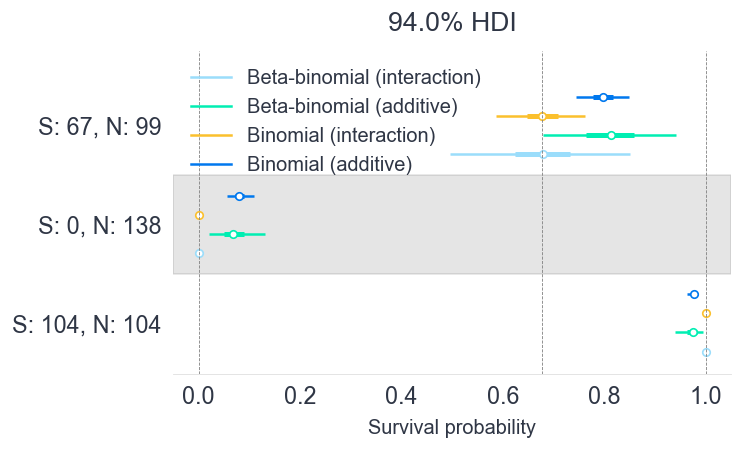

In [44]:
fig, ax = plt.subplots(figsize=(6, 3.5))

ylabels = [
    f"S: {y}, N: {n}" 
    for y, n in zip(df_scenarios["survive"], df_scenarios["total"])
]

az.plot_forest(     
    [
        idata_model_additive, 
        idata_model_interaction,
        idata_model_bb_additive,
        idata_model_bb_interaction
    ],
    model_names=[
        "Binomial (additive)", 
        "Binomial (interaction)",
        "Beta-binomial (additive)",
        "Beta-binomial (interaction)"
    ],
    var_names=["p(survive, total)_mean"],
    combined=True,
    ax=ax,
)

ax.axvline(0, ls="--", lw=0.5, color="0.5")
ax.axvline(67/99, ls="--", lw=0.5, color="0.5")
ax.axvline(1, ls="--", lw=0.5, color="0.5")
ax.set(xlabel="Survival probability", yticklabels=reversed(ylabels));

There are many interestings to see here. Let's cover the three cases one by one.

**Case 1**: We observed 67 out of 99 eggs survived (67.7%). The additive models are not containing the empirical proportion while the interaction models do. What's more, the models that consider the interaction between `location` and `sector` are perfectly centered around the empirical proportion. In principle, this can lead us think the models with interactions are better.

**Case 2**: No eggs out of 138 survived (0%). The empirical value is in the boundary of the parameter space (i.e. the [0, 1] interval). Again, the posterior mean of the interaction models match the empirical values and the additive models don't contain them. However, this time, we see there's almost no uncertainty in the posteriors of the interaction models. This is not a good thiing _per se_! 

**Case 3**: It's exactly like **Case 2**, but all the eggs survived. 

What's the conclusion so far? One may be tempted to conclude that the binomial model with interaction is the best, as the posterior of the survival probability is centered around the empirical value... However, it's not all that easy in stats. Let's go to **Part 4**.

**Part 4**

The procedure here is quite similar to the one in **Part 3** of **Exercise 5**. We grab the draws from the predictive distribution, and manipulate them in order to visualize it. The complexity increases because we have three groups and four models.

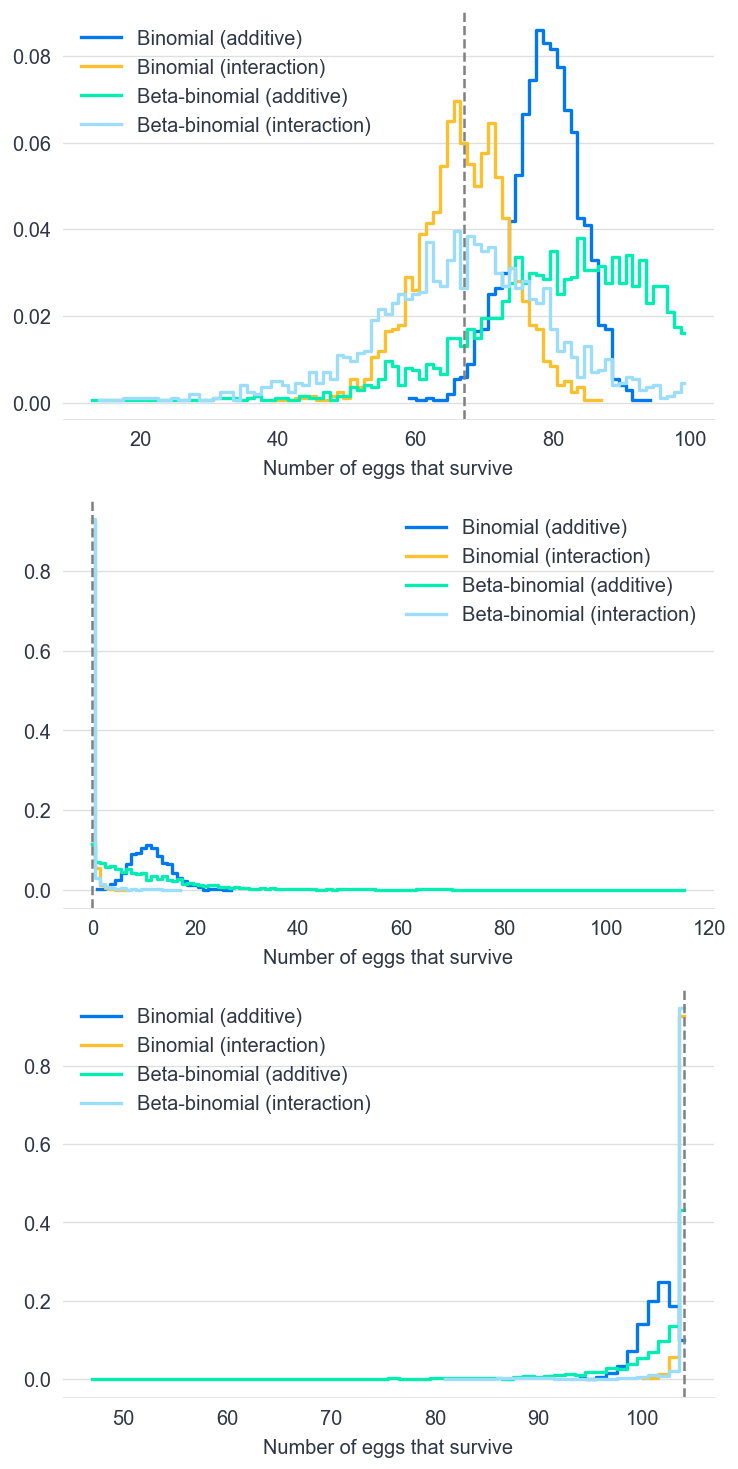

In [45]:
labels = [
    "Binomial (additive)", 
    "Binomial (interaction)",
    "Beta-binomial (additive)",
    "Beta-binomial (interaction)"
]

pp_bin_add = idata_model_additive.posterior_predictive["p(survive, total)"].to_numpy()
pp_bin_int = idata_model_interaction.posterior_predictive["p(survive, total)"].to_numpy()
pp_bb_add = idata_model_bb_additive.posterior_predictive["p(survive, total)"].to_numpy()
pp_bb_int = idata_model_bb_interaction.posterior_predictive["p(survive, total)"].to_numpy()

y_survive = df_scenarios["survive"].to_numpy()

fig, axes = plt.subplots(3, 1, figsize=(7, 15))

for i, ax in enumerate(axes):
    values_bin_add = pp_bin_add[..., i].flatten()
    values_bin_int = pp_bin_int[..., i].flatten()
    values_bb_add = pp_bb_add[..., i].flatten()
    values_bb_int = pp_bb_int[..., i].flatten()

    arrays = [values_bin_add, values_bin_int, values_bb_add, values_bb_int]

    for label, arr in zip(labels, arrays):
        values, counts = np.unique(arr, return_counts=True)
        ax.step(values, counts / counts.sum(), where="mid", linewidth=2, label=label)

    ax.axvline(y_survive[i], ls="--", color="gray")
    ax.legend()
    ax.set(xlabel="Number of eggs that survive");

Alright, a lot can be said here. 

First, notice the gray lines indicate the observed number of eggs that survived. A "good" model should have this line in a region of non-negligible probability.

In the first scenario, we see that all the models but the additive binomial regression result in a sensible predictive distribution. But the interesting things are happening in the other two cases.

Both models with interaction are giving a lot of probability to the observed values. 0 in the first case and 104 in the second case have a probability above 90% (see the height of the step function). This is quite a lot, isn't it?

On the other hand, we see the binomial additive model doesn't do great (it does a bit better for the third case, but not for the second), but the beta binomial model does a much better job in all cases.

With the beta-binomial model, the three scenarios we evaluated turn out to be plausible under the posterior predictive distribution we get, even when the empirical probability is in the boundary of the parameter space. However, as we have seen in the lesson, this is not free. We can notice an increase in the variability that is reflected in the long tails in green.

**Part 5**

The first model, binomial with additive effects, turns out to be simplistic under the cases we evaluated it. It just can't capture the more extreme scenarios. It may still be valid in some cases where one may want to tolerate some bias in exchange for a lower variance.

The second model, where we included interaction effects in the binomial regression, seemed to be quite good. However, we saw it suffers from "over-confidence". There's a reason for this. In this model we have n_locations * n_periods groups, and we have n_locations * n_periods parameters. Each parameter simply represents the mean survival probability in the group. The take-home message is that models like this are prone to overfit.

Now let's talk about the beta-binomial models. The one with interaction suffers the same drawbacks as the binomial model with interaction. Plus, it's more complex and results in extra variance. And finally, what I think ends up being the best model here, is the beta binomial model with additive effects. It doesn't have the problem of overfitting every case, it's not confident in excess, and the observed values are plausible under the predictive distributions. The drawback is that the extra variability may be too much in some cases.

## Exercise 7 [Hard]

**_Revisiting the fish species dataset with PyMC - Part 2._**

Consider the Poisson regression model that we have already built:

$$
\begin{aligned}
\text{species}_i &\sim \text{Poisson}(\mu_i) \\
\mu_i &= \exp[\beta_0 + \beta_1 \log(\text{area}_i)] \\
\beta_0 &\sim \text{Normal} \\
\beta_1 &\sim \text{Normal}
\end{aligned}
$$


1. What does the intercept mean in the  model? Does it make sense to interpret it?
2. What transformation can be performed to the lake area in order to make the intercept $\beta_0$ be related to the number of species of a lake of average size?
3. What is needed to make the intercept $\beta_0$ relate to the number of species of a lake of 1000 squared kilometers?
4. Write and fit both models in PyMC. Then:
    1.  Using the first model, predict the mean number of species for a lake of 1000 squared kilometers.
    2.  Using the second model, predict the mean number of species for a lake of average size.
    3.  Compare these values with the posterior mean of $\beta_0$ in both models.
5.  What can you conclude?

### Solution

In [46]:
df_lakes = pd.read_csv("data/lakes.csv")
df_lakes.head()

,fish,lake_area
0,10,5
1,37,41
2,60,171
3,113,25719
4,99,59596


**Part 1**

Let's write down the important parts again:

$$
\begin{aligned}
\mu_i &= \exp\left[\beta_0 + \beta_1 \log(\text{area}_i) \right] \\
\log(\mu_i) &= \beta_0 + \beta_1 \log(\text{area}_i)
\end{aligned}
$$

To interpret the intercept we need to find when the slope is multiplied by 0. Since the $\beta_1$ multiplies a logarithm, we know it'll be zero whenever the argument is 1, i.e. $\text{area}_i = 1$. In this case, we'll have $\log(\mu_i) = \beta_0$ and thus $\mu_i = \exp(\beta_0)$. 

In other words, $\exp(\beta_0)$ is the **mean number of fish species in a lake of one squared kilometer**.

**Part 2**

$\exp(\beta_0)$ is the mean when $\text{area}_i$ is equal to 1 because that value makes the logarithm equal to zero.

If we want to relate the intercept to a lake of average size, we need some transformation that makes the logarithm at the mean lake size equal to one. To get that, we just need to replace $\text{area}_i$ with $\text{area}_i / \overline{\text{area}}$. In other words, we transform our predictor dividing it by its mean. See below:

$$
\begin{aligned}
\mu_i &= \exp\left[\beta_0 + \beta_1 \log(\text{area}_i / \overline{\text{area}}) \right] \\
\log(\mu_i) &= \beta_0 + \beta_1 \log(\text{area}_i / \overline{\text{area}})
\end{aligned}
$$

Here, $\log(\text{area}_i / \overline{\text{area}})$ will be zero when the area is equal to the mean because 

$$
\log(\overline{\text{area}} / \overline{\text{area}}) = \log(1) = 0
$$

And in this case, $\exp(\beta_0)$ will represent the **mean number of species for a lake of average size**.

**Part 3**

We can use the same logic as before. Instead of dividing by the mean, we divide by any other reference value we want. This way, we can divide by 1000 and then $\exp(\beta_0)$ becomes the average number of species for a lake of 1000 squared kilometers.

**Part 4**

Let's write down the models in PyMC. This should be familiar from Lesson 7 and some of Lesson 8. Just notice the code that modifies the predictor with the appropriated transformations.

In [47]:
fish_count = df_lakes["fish"].to_numpy()
lake_area = df_lakes["lake_area"].to_numpy()

with pm.Model() as model_mean:
    intercept = pm.Normal("intercept", mu=4, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=1)
    mu = pm.math.exp(intercept + slope * np.log(lake_area / np.mean(lake_area)))
    pm.Poisson("fish_count", mu=mu, observed=fish_count)
    idata_mean = pm.sample(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [48]:
fish_count = df_lakes["fish"].to_numpy()
lake_area = df_lakes["lake_area"].to_numpy()

with pm.Model() as model_1000:
    intercept = pm.Normal("intercept", mu=2, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=1)
    mu = pm.math.exp(intercept + slope * np.log(lake_area / 1000))
    pm.Poisson("fish_count", mu=mu, observed=fish_count)
    idata_1000 = pm.sample(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Now, let's have a look at something interesting: the posterior mean of the parameters.

In [49]:
az.summary(idata_mean, kind="stats")

,mean,sd,hdi_3%,hdi_97%
intercept,4.197,0.021,4.159,4.237
slope,0.205,0.007,0.193,0.218


In [50]:
az.summary(idata_1000, kind="stats")

,mean,sd,hdi_3%,hdi_97%
intercept,3.557,0.023,3.516,3.603
slope,0.205,0.007,0.192,0.218


First, the coincidences. In both cases the `slope` results in the same posterior mean, even when we're chaging the scale in the predictor 🤯! 

Actually, this makes sense. The log link function (or exp inverse link function) are converting this model from additive to multiplicative. So the 'slope' is reflecting the factor by which we multiply some baseline quantity as we increase the value of the predictor in 1%. If you're curious about this, we covered something similar in the appendix of Lesson 2. Also, don't hesitate to ask about it on Discourse :)

Now, the things that don't match: the intercepts. It should be expected, though, as we showed it in the math. The intercepts refer to different things (see **Part 2** and **Part 3** of this exercise).

We could use the PyMC machinery to predict the requested means, but since this are two simple models, we can grab the draws from the posterior distribution and compute the predictions ourselves.

In [51]:
# Predict the mean for a lake of size 1000 using the model that divides
result_1 = (
    np.exp(
        idata_mean.posterior["intercept"] 
        + idata_mean.posterior["slope"] * np.log(1000 / np.mean(lake_area))
    )
    .mean()
    .item()
)

# Predict the mean for a lake of average size using the model that divides by 1000
result_2 = (
    np.exp(
        idata_1000.posterior["intercept"] 
        + idata_1000.posterior["slope"] * np.log(np.mean(lake_area) / 1000)
    )
    .mean()
    .item()
)

print(result_1)
print(result_2)

35.108010694746
66.45469892712298


There doesn't seem to be anything special here... right?

Until we realize we need to compute the logarithm of these values, as the intercepts are in a logarithmic scale.

**Part 5**

In [52]:
print(np.log(result_1))
print(np.log(result_2))

3.558429329354013
4.196520496385612


Ta da 🎉! 

Well, they seem to be two random numbers. But they are not. If you check the summaries above, the first number, that was computed with the first model, is the intercept of the second model. And the second number, computed with the second model, is the intercept of the first model. 

The bottom-line is not that complicated: No matter how we parametrize a model or transform the data, estimations for the same quantities should be the same (or very close). And this is what we just verified with this example.

## Exercise 8 [Hard]

**_The non-identifiability playground._**

Consider the additive trout eggs model created in a previous exercise.

Below we propose several model implementations that are not completely correct.

Explain what is the problem in each of the cases and propose at least one solution (written in PyMC).

It can be useful to revisit all the content about parameter non-identifiability in the course.

In [53]:
# Setup
survive = df_eggs["survive"].to_numpy()
total = df_eggs["total"].to_numpy()
location, location_idx = np.unique(df_eggs["location"], return_inverse=True)
period, period_idx = np.unique(df_eggs["period"], return_inverse=True)

coords = {
    "location": location,
    "period": period
}

**Model 1**

In [54]:
with pm.Model(coords=coords) as model_1:
    intercept = pm.Normal("intercept")
    b_location = pm.Normal("b_location", dims="location")
    b_period = pm.Normal("b_period", dims="period")
    mu = intercept + b_location[location_idx] + b_period[period_idx]
    p = pm.math.invlogit(mu)
    pm.Binomial("survive", p=p, n=total, observed=survive)

**Model 2**

In [55]:
with pm.Model(coords=coords) as model_2:
    b_location = pm.Normal("b_location", dims="location")
    b_period = pm.Normal("b_period", dims="period")
    mu = b_location[location_idx] + b_period[period_idx]
    p = pm.math.invlogit(mu)
    pm.Binomial("survive", p=p, n=total, observed=survive)

**Model 3**

In [56]:
with pm.Model(coords=coords) as model_3:
    intercept = pm.Normal("intercept")
    b_location = pm.ZeroSumNormal("b_location", dims="location")
    b_period = pm.Normal("b_period", dims="period")
    mu = intercept + b_location[location_idx] + b_period[period_idx]
    p = pm.math.invlogit(mu)
    pm.Binomial("survive", p=p, n=total, observed=survive)

**Model 4**

In [57]:
with pm.Model(coords=coords) as model_4:
    intercept = pm.Normal("intercept")
    b_location = pm.Normal("b_location", dims="location")
    b_period = pm.ZeroSumNormal("b_period", dims="period")
    mu = intercept + b_location[location_idx] + b_period[period_idx]
    p = pm.math.invlogit(mu)
    pm.Binomial("survive", p=p, n=total, observed=survive)

### Solution

* Model 1: There's an intercept, and two categorical covariates with no constraints. Thus, the categorical covariates are confounded among them, and at the same time they're confounded with the intercept.  
* Model 2: The intercept is not there, so categorical covariates are not confounded with it anymore. However, since no constraints are imposed on them, they're confounded between them.
* Model 3: This is like Model 1, but one of the categorical covariates is imposed a zero-sum constraint. This is still not enough to remove all non-identifiabilities as the other categorical covariate is still confounded with the intercept.
* Model 4: This is exactly like Model 3, but the zero-sum constraint is imposed on the other covariate.


In [58]:
import pytensor.tensor as pt

**Solution 1**

Uses an intercept, also known as baseline, and imposes zero-sum constraints on the vector of parameters for both categorical predictors. 

In [59]:
with pm.Model(coords=coords) as model_4:
    intercept = pm.Normal("intercept")
    b_location = pm.ZeroSumNormal("b_location", dims="location")
    b_period = pm.ZeroSumNormal("b_period", dims="period")
    mu = intercept + b_location[location_idx] + b_period[period_idx]
    p = pm.math.invlogit(mu)
    pm.Binomial("survive", p=p, n=total, observed=survive)

**Solution 2**

Uses an intercept, and imposes a constraint on the first level of both categorical predictors, forcing them to be equal to zero.

In [60]:
with pm.Model(coords=coords) as model_1s:
    intercept = pm.Normal("intercept")

    b_location_reduced = pm.Normal("b_location_reduced", shape=len(location) - 1)
    b_location = pm.Deterministic("b_location", pt.concatenate([pt.zeros(1), b_location_reduced]), dims="location")

    b_period_reduced = pm.Normal("b_period_reduced", shape=len(period) - 1)
    b_period = pm.Deterministic("b_period", pt.concatenate([pt.zeros(1), b_period_reduced]), dims="period")

    mu = intercept + b_location[location_idx] + b_period[period_idx]
    p = pm.math.invlogit(mu)
    pm.Binomial("survive", p=p, n=total, observed=survive)

**Solution 3**

This is a bit more exotic. It doesn't use an intercept, so it can allow all the coefficients of one categorical covariate freely, but it needs to impose a constraint on the coefficients of the second categorical covariate. In this case, we use a zero-sum constraint for simplicity but we could also fix the coefficient of some level to zero.

In [61]:
with pm.Model(coords=coords) as model_1s:
    b_location = pm.Normal("b_location", dims="location")
    b_period = pm.ZeroSumNormal("b_period", dims="period")
    mu = intercept + b_location[location_idx] + b_period[period_idx]
    p = pm.math.invlogit(mu)
    pm.Binomial("survive", p=p, n=total, observed=survive)